# Домашнее задание №10
## Логистическая регрессия. Часть 1.
### PROC LOGISTIC

_[Гончаренко Дмитрий Александрович, Жуков Павел Николаевич, Слабоузова Анна Константиновна]_

### 0. Подготовка файлов для выполнения ДЗ.

- НАБОР ДАННЫХ ДЛЯ ЗАДАНИЯ: HW10_DATA.csv (в слайдах на лекции он назывался 'develop', там же можно посмотреть список переменных)

Ответьте на вопросы ниже, не забудьте указать все, на что Вы обратили внимание, отвечая на вопрос, делая соответствующие выводы (график/таблицу/статистику/p-value/прочее).

### Задание


### 1. Предварительное  исследование данных  
#### 1.1 Посмотрите на статистики и распределения переменных.

In [1]:
/* загружаем данные */
proc import file="HW10_DATA.csv"
    out=develop 
    DBMS=CSV
    REPLACE;
run;    

/* Смотрим на статистику переменных в develop, 
также на N для определения переменных, у которых
есть пропущенные значения*/
title 'Develop statistics';
proc means data=develop;
run;

/* Смотрим на Cumulative Frequency, последнюю строку,
чтобы понять, сколько всего наблюдений для конкретной 
категориальной переменной*/
proc freq data=develop;
tables _character_;
run;

SAS Connection established. Subprocess id is 2738



In [2]:
/* Находим количество всех наблюдений. 32264*/
data _null_;
    set develop nobs=number_obs;
    put "NUMBER OF ALL OBSERVATIONS == " number_obs;
    stop;
run;

#### Q1.1: Укажите все переменные, в которых встречаются пропущенные значения:
AcctAge, Phone, POS, POSAmt, CC, CCBal, CCPurc, Income, HMOwn, LORes, HMVal, Age, CRScore, Inv, InvBal

Переменные были получены следующим образом: в ячейке сверху получено количество всех наблюдений в наборе develop. Значение равно 32264. Затем с помощью процедуры means получены N (количество непустых значений) для каждой числовой переменной. 

#### 1.2 Разделите набор на две части: train и test. 
Далее всю разработку мы проводим на части train, а к test мы применяем полученный результат. См. ex_train_val.sas

In [3]:
%include 'ex_TRAIN_VAL.sas'

In [4]:
data train test;
    set develop;
    if Selected=1 then output train;
    else output test;
    drop Selected SelectionProb SamplingWeight;
run;

title 'Statistics for train';
proc means data=train; run;
title 'Statistics for test';
proc means data=test; run;

Variable,N,Mean,Std Dev,Minimum,Maximum
Ins AcctAge DDA DDABal CashBk Checks DirDep NSF NSFAmt Phone Teller Sav SavBal ATM ATMAmt POS POSAmt CD CDBal IRA IRABal LOC LOCBal ILS ILSBal MM MMBal MMCred MTG MTGBal CC CCBal CCPurc SDB Income HMOwn LORes HMVal Age CRScore Moved InArea Dep DepAmt Inv InvBal,21512 20129 21512 21512 21512 21512 21512 21512 21512 18748 21512 21512 21512 21512 21512 18748 18748 21512 21512 21512 21512 21512 21512 21512 21512 21512 21512 21512 21512 21512 18748 18748 18748 21512 17648 17810 17648 17648 17255 21037 21512 21512 21512 21512 18748 18748,0.3463648 5.8970242 0.8142432 2134.01 0.0158981 4.2418185 0.2951841 0.0866493 2.2801162 0.4058566 1.3571960 0.4679249 3185.64 0.6101711 1212.39 1.0737145 49.2781134 0.1246281 2549.68 0.0534120 637.6168083 0.0635459 1166.24 0.0496467 517.4270695 0.1157493 1887.18 0.0577352 0.0498791 8235.93 0.4846384 9911.12 0.1530830 0.1090554 40.4070150 0.5405390 7.0054964 110.8284791 48.0136772 666.6091648 0.0295184 0.9600223 2.1299275 2186.60 0.0297632 1732.58,0.4758222 6.4884305 0.3889193 7019.27 0.1319569 5.1385258 0.4561361 0.2813270 14.1500294 1.2080886 2.2837743 0.4989817 13824.39 0.4877227 3811.12 2.9198146 138.9423023 0.3303044 15513.42 0.2248590 8248.43 0.2439480 9797.63 0.2172190 2281.85 0.3199315 5496.84 0.2912172 0.2177003 91271.46 0.4997773 94409.42 0.4466916 0.3117160 28.4985064 0.4983679 2.8455099 22.0086320 14.0912277 40.2776590 0.1692584 0.1959113 1.7287578 6531.31 0.1699378 67223.63,0 0.3000000 0 -774.8300000 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -16.4000000 0 0 0 0 0 0 0 0 -2060.51 0 0 0 0 0.5000000 67.0000000 16.0000000 509.0000000 0 0 0 0 0 -2214.92,1.0000000 61.5000000 1.0000000 259734.26 3.0000000 49.0000000 1.0000000 1.0000000 632.8400000 30.0000000 27.0000000 1.0000000 700026.94 1.0000000 130071.76 54.0000000 3293.49 1.0000000 1053900.00 1.0000000 596497.60 1.0000000 523147.24 1.0000000 26806.59 1.0000000 107028.55 5.0000000 1.0000000 10887573.28 1.0000000 10641354.78 5.0000000 1.0000000 233.0000000 1.0000000 18.5000000 754.0000000 94.0000000 820.0000000 1.0000000 1.0000000 28.0000000 484893.67 1.0000000 8323796.02
Variable,N,Mean,Std Dev,Minimum,Maximum
Ins AcctAge DDA DDABal CashBk Checks DirDep NSF NSFAmt Phone Teller Sav SavBal ATM ATMAmt POS POSAmt CD CDBal IRA IRABal LOC LOCBal ILS ILSBal MM MMBal MMCred MTG MTGBal CC CCBal CCPurc SDB Income HMOwn LORes HMVal Age CRScore Moved InArea Dep DepAmt Inv InvBal,10752 10065 10752 10752 10752 10752 10752 10752 10752 9383 10752 10752 10752 10752 10752 9383 9383 10752 10752 10752 10752 10752 10752 10752 10752 10752 10752 10752 10752 10752 9383 9383 9383 10752 8834 8921 8834 8834 8652 10520 10752 10752 10752 10752 9383 9383,0.3463542 5.9319821 0.8184524 2242.06 0.0160900 4.2961310 0.2963170 0.0878906 2.3114146 0.4050943 1.3814174 0.4648438 3140.52 0.6094680 1281.47 1.0796121 48.2229831 0.1282552 2492.75 0.0530134 577.4628330 0.0630580 1193.19 0.0494792 517.8536700 0.1131882 1852.93 0.0536644 0.0482701 7773.24 0.4800171 8938.03 0.1563466 0.1078869 40.9523432 0.5445578 7.0059995 111.0792393 47.7580906 666.2622624 0.0298549 0.9608445 2.1439732 2325.12 0.0295215 1332.61,0.4758298 6.5912730 0.3854892 7782.96 0.1301875 5.1927512 0.4566537 0.2831489 14.7825096 1.1821542 2.2837666 0.4987857 12499.16 0.4878923 5539.83 2.8255905 133.1943988 0.3343893 13297.92 0.2240706 5780.67 0.2430786 9208.82 0.2168764 2291.96 0.3168375 5459.84 0.2798600 0.2143464 49387.75 0.4996271 45254.72 0.4487886 0.3102520 28.5459997 0.4980386 2.8231423 21.8324428 14.1491742 40.6839373 0.1701949 0.1939738 1.7078264 7037.03 0.1692720 26287.92,0 0.3000000 0 -399.5300000 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -613.0000000 0 0 0 0 0 0 0 0 -1903.99 0 0 0 0 0.5000000 68.0000000 16.0000000 526.0000000 0 0 0 0 0 0,1.0000000 59.8000000 1.0000000 278093.83 4.0000000 48.0000000 1.0000000 1.0000000 666.8500000 17.0000000 23.0000000 1.0000000 327083.18 1.0000000 427731.26 35.0000000 2546.25 1.0000000 688700.00 1.0000000 285339.77 1.0000000 363133.10 1.0000000

#### Q1.2: Можно ли утверждать, что распределение целевой переменной в частях train и test почти одинаковое? 
Можно, так как наборы формировались таким образом, что у них равное соотношение данных с различным ins.
То есть если посмотреть на вывод процедур means для train и test, то можно увидеть поле mean для ins практически одинаковое.

#### Q1.3: Какой оператор контролирует похожесть распределения? 
strata ins в процедуре SURVEYSELECT 

### 2. Выбор моделей кандидатов

#### 2.1 Выберите 2 модели, используя метод all subsets regression (и Хи-квадрат как метрику качества).

In [5]:
title 'All subsets regression';
proc logistic data=train;
    model ins(event='1') = AcctAge DDA DDABal CashBk Checks DirDep 
                        NSF NSFAmt Phone Teller Sav SavBal ATM ATMAmt
                        POS POSAmt CD CDBal IRA IRABal LOC LOCBal ILS
                        ILSBal MM MMBal MMCred MTG MTGBal CC CCBal CCPurc
                        SDB Income HMOwn LORes HMVal Age CRScore Moved InArea
                        Dep DepAmt Inv InvBal / selection=SCORE
        best = 3
        start= 1
        stop = 7;
    ods output bestsubsets=work.score responseprofile=work.profile;
run;

#### Q2.1 Почему вы выбрали их?
Выбраны модели с максимальным значением хи-квадрат для модели с 6 параметрами. 
Количество 6 - показалось оптимальным ввиду того, для 7 параметров значение хи-квадрат практически такое же как для 6. То есть особого выиграша 7-ой параметр не приносит. 
#### Q2.2 Какие переменные вошли в модели, которые вы выбрали?
В первую модель: `DDA DDABal Sav SavBal CD MM`.
Во вторую модель: `DDA DDABal Sav SavBal CD MMBal`.

#### 2.2 Исследование выбранных моделей.

 - Постройте выбранные модели (т.е. оцените коэффициенты при переменных). 
 - Примените их к набору test. 
 - Постройте K-S (`PROC NPAR1WAY`) и ROC (`PROC LOGISTIC`) на наборах train и test. Оцените «устойчивость» модели. (см. ex_KS.sas и ex_ROC_comp.sas)



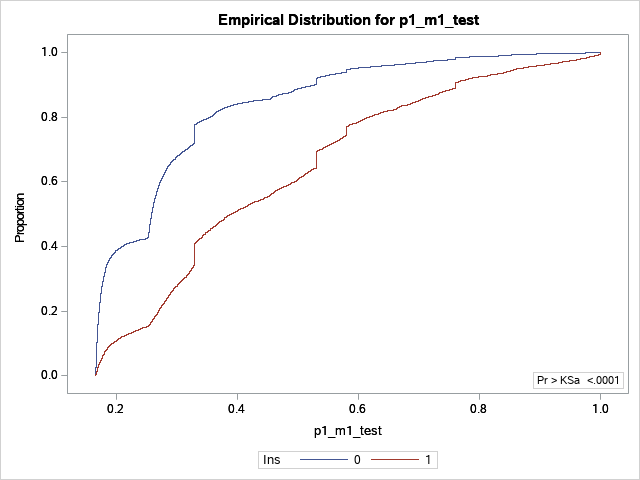
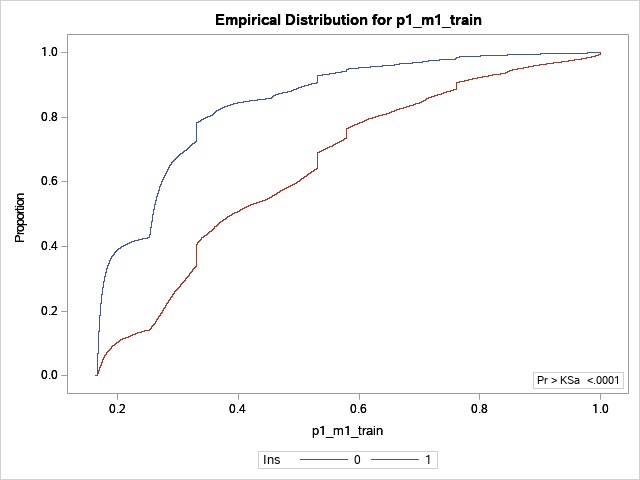
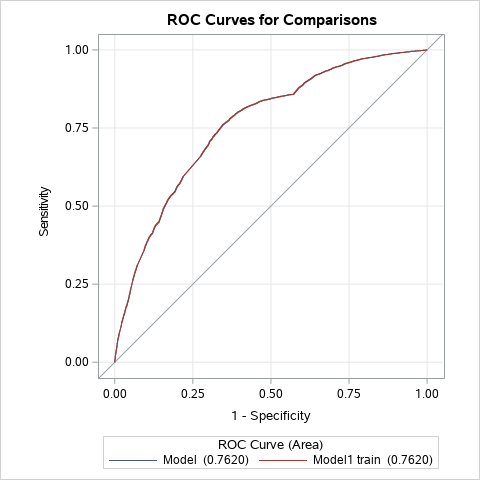
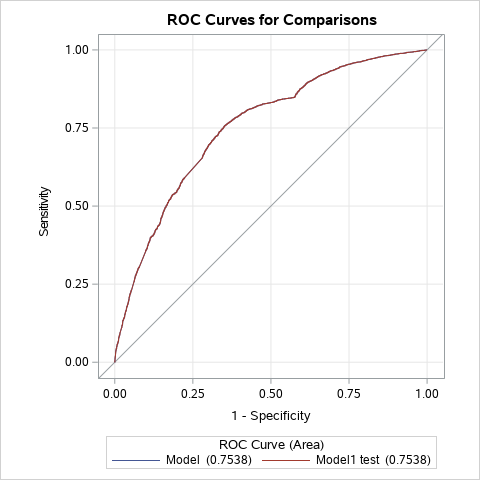

In [6]:
/* Первая модель*/
proc logistic data=train noprint;
    model ins(event='1')=DDA DDABal Sav SavBal CD MM / selection=stepwise;
    code file='logreg_scorecode_m1.sas';
run;

data Model1_Test;
    set test;
    %include 'logreg_scorecode_m1.sas';
    p1_m1_test = P_Ins1;
    keep ins p1_m1_test;
run;

data Model1_Train;
    set train;
    %include 'logreg_scorecode_m1.sas';
    p1_m1_train = P_Ins1;
    keep ins p1_m1_train;
run;

proc npar1way edf data=Model1_Test;
   class ins;
   var p1_m1_test;
   title "First model K-S Statistic for the test dataset";
run;

proc npar1way edf data=Model1_Train;
   class ins;
   var p1_m1_train;
   title "First model K-S Statistic for the train dataset";
run;


ods select ROCOverlay ROCAssociation;
proc logistic data=Model1_Train;
   model ins(event='1')=p1_m1_train;
   roc "Model1 train" p1_m1_train;
   title "Train Data Set Performance";
run;

ods select ROCOverlay ROCAssociation;
proc logistic data=Model1_Test;
   model ins(event='1')=p1_m1_test;
   roc "Model1 test" p1_m1_test;
   title "Test Data Set Performance";
run;


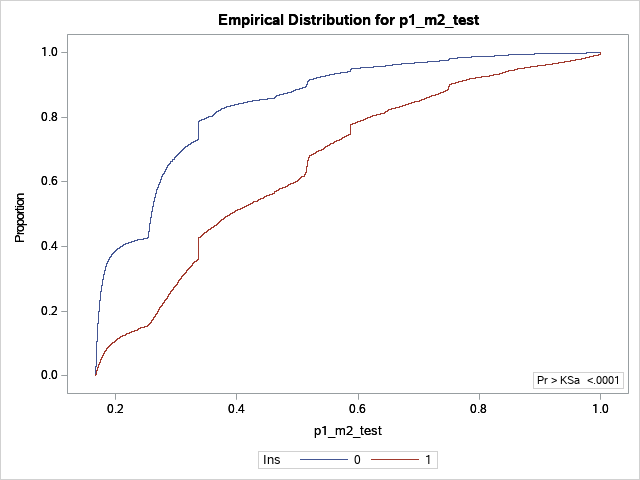
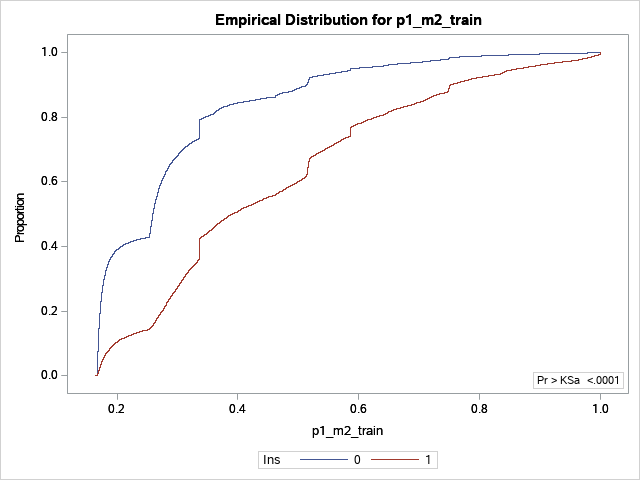
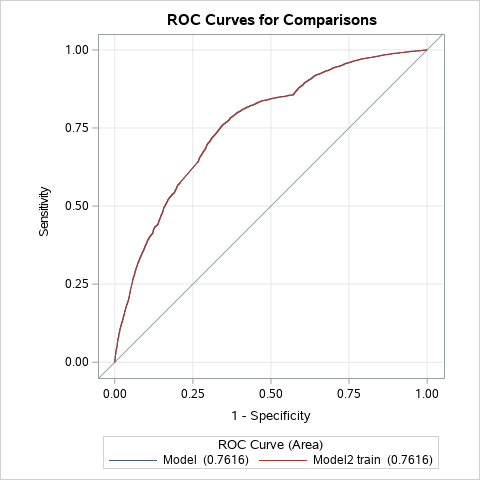
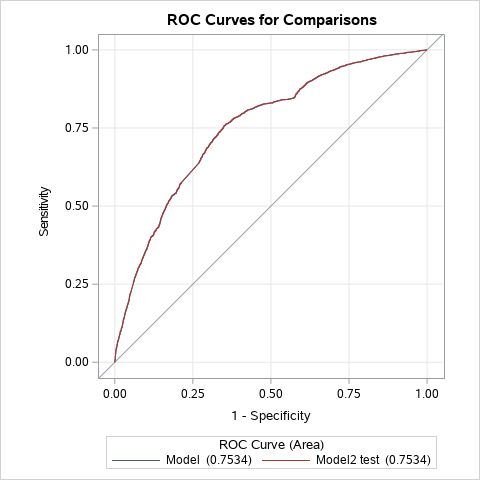

In [7]:
/* Вторая модель */
proc logistic data=train noprint;
    model ins(event='1')=DDA DDABal Sav SavBal CD MMBal / selection=stepwise;
    code file='logreg_scorecode_m2.sas';
run;

data Model2_Test;
    set test;
    %include 'logreg_scorecode_m2.sas';
    p1_m2_test = P_Ins1;
    keep ins p1_m2_test;
run;

data Model2_Train;
    set train;
    %include 'logreg_scorecode_m2.sas';
    p1_m2_train = P_Ins1;
    keep ins p1_m2_train;
run;

proc npar1way edf data=Model2_Test;
   class ins;
   var p1_m2_test;
   title "Second model K-S Statistic for the test dataset";
run;

proc npar1way edf data=Model2_Train;
   class ins;
   var p1_m2_train;
   title "Second model K-S Statistic for the train dataset";
run;


ods select ROCOverlay ROCAssociation;
proc logistic data=Model2_Train;
   model ins(event='1')=p1_m2_train;
   roc "Model2 train" p1_m2_train;
   title "Train Data Set Performance";
run;

ods select ROCOverlay ROCAssociation;
proc logistic data=Model2_Test;
   model ins(event='1')=p1_m2_test;
   roc "Model2 test" p1_m2_test;
   title "Test Data Set Performance";
run;

#### Q2.3 Все ли коэффициенты в обеих моделях значимые?
Да. Определялось по полям `Pr>ChiSq` напротив каждой переменной.
#### Q2.4 Модели устойчивы? Как вы пришли к такому выводу? Какие шаги вы бы предложили предпринять для дальнейшего повышения устойчивости моделей?
Модели устойчивы, так как ROC AUC у каждой модели примерно равны как для тестовой выборки(`~0.75`), так и для тренировочной(`~0.76`). В данном случае обучение проводилось на тренировочном датасете, данные в тренировочном и тестовом датасетах сбалансированы относительно целевой переменной ins. И значения достаточно ROC AUC близки. Поэтому, возможно, уже не критично повышать устойчивость моделей. Но если бы было нужно, следующим этапом стало бы применение кросс-валидации.
#### Q2.5 Чему равен индекс Джини для обеих моделей на train и test?
Индекс Джини получается из ROC AUC следующим образом: `2*AUC-1`. 
1. 1-ая модель: 
    1. train 0.5240
    2. test 0.5076
2. 2-ая модель: 
    1. train 0.5232 
    2. test 0.5068.